In [3]:
import numpy as np

In [2]:
from functions import extract_xy
from functions import spline_interpolate
from functions import smooth
from functions import compute_kinematics

In [4]:
import json
folder_path_back = "Data hit & bounce/per_point_v2"
with open(f"{folder_path_back}/ball_data_{111}.json", 'r') as f:
    ball_data = json.load(f)
first_frame = int(list(ball_data.keys())[0])

bounce_frames = [int(key) for key, value in ball_data.items() if value['action'] == 'bounce']

hit_frames = [int(key) for key, value in ball_data.items() if value['action'] == 'hit']
real_hits = np.array(hit_frames) - first_frame
real_bounces = np.array(bounce_frames) - first_frame

In [ ]:
t, x_raw, y_raw = extract_xy(ball_data)
x_interp = spline_interpolate(t, x_raw, max_gap=10)
y_interp = spline_interpolate(t, y_raw, max_gap=10)
x_s = smooth(x_interp)
y_s = smooth(y_interp)
vx, vy, ax, ay = compute_kinematics(t, x_s, y_s)


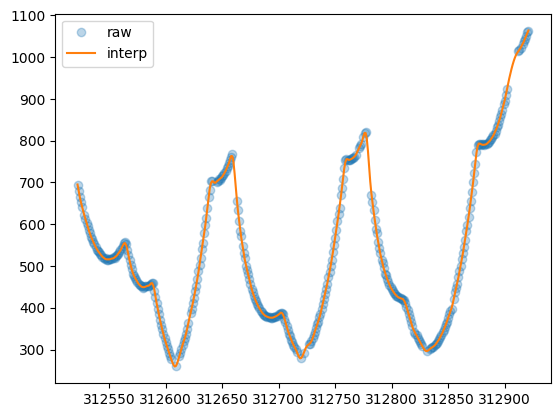

In [171]:
import matplotlib.pyplot as plt
plt.plot(t, y_raw, 'o', alpha=0.3, label='raw')
plt.plot(t, y_s, '-', label='interp')
plt.legend()
plt.show()


In [ ]:

def velocity_score(vx, vy):
    return np.sqrt(vx**2 + vy**2)
def acceleration_score(ax, ay):
    return np.sqrt(ax**2 + ay**2)
v_score = velocity_score(vx, vy)
a_score = acceleration_score(ax, ay)


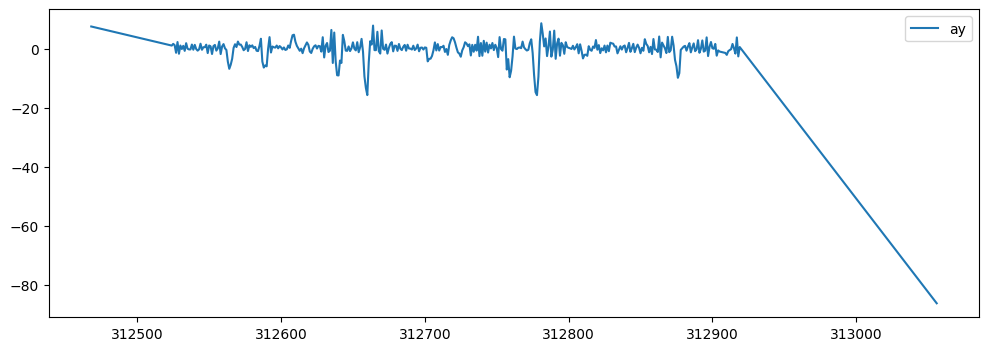

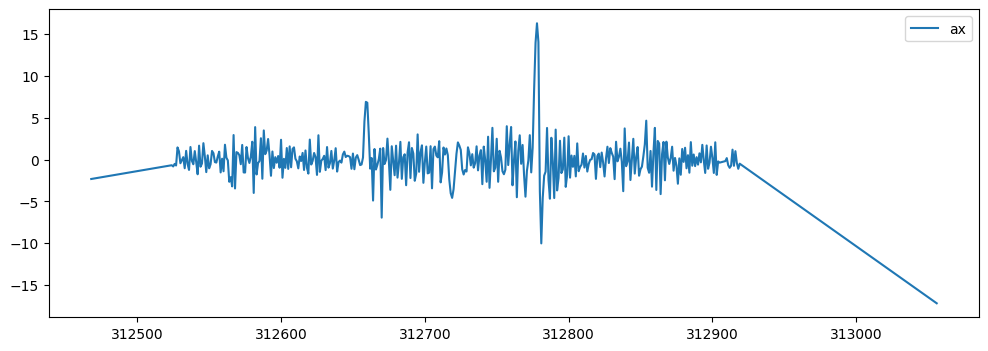

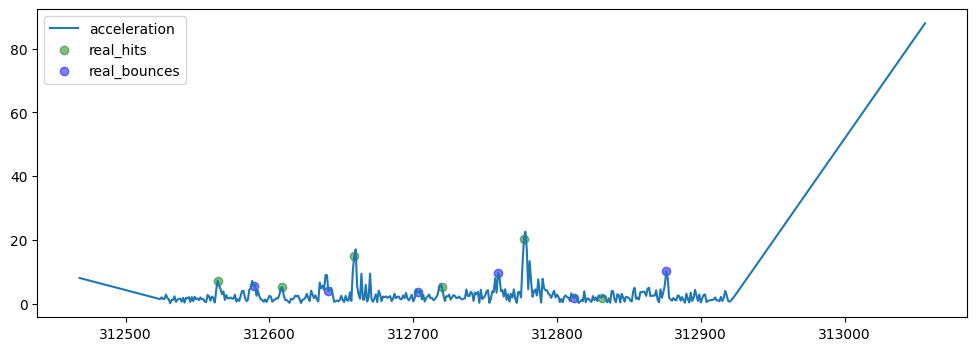

In [175]:

plt.figure(figsize=(12,4))
plt.plot(t, ay, label='ay')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, ax, label='ax')
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, np.sqrt(ax**2 + ay**2), label='acceleration')
plt.scatter(t[real_hits], a_score[real_hits], c='g', label="real_hits", alpha=0.5)
plt.scatter(t[real_bounces], a_score[real_bounces], c='b', label="real_bounces", alpha=0.5)
plt.legend()
plt.show()

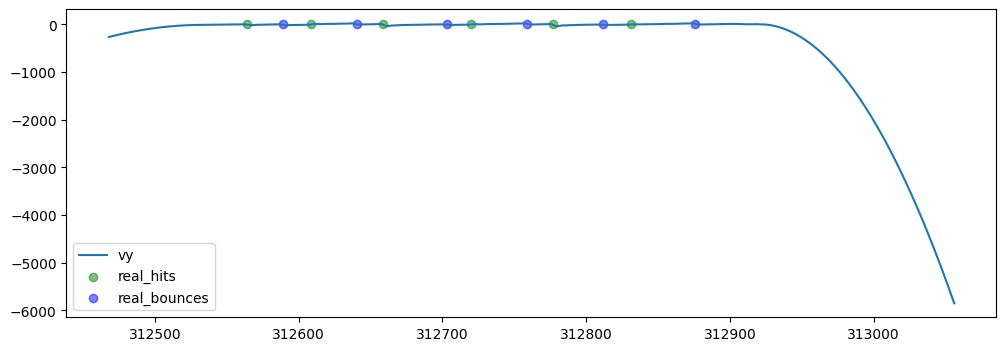

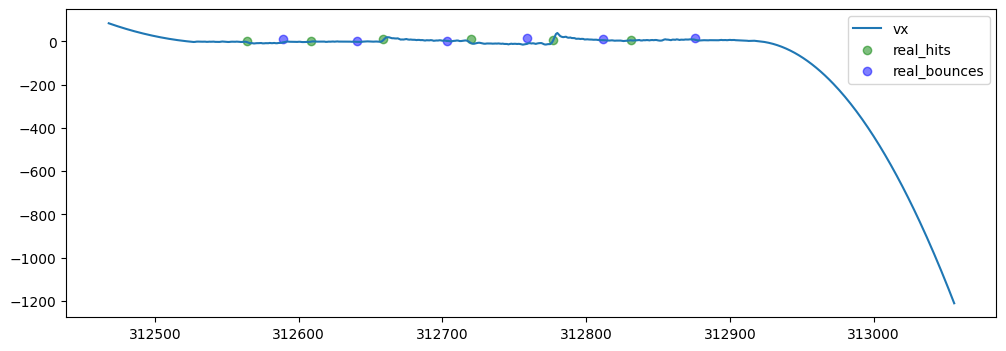

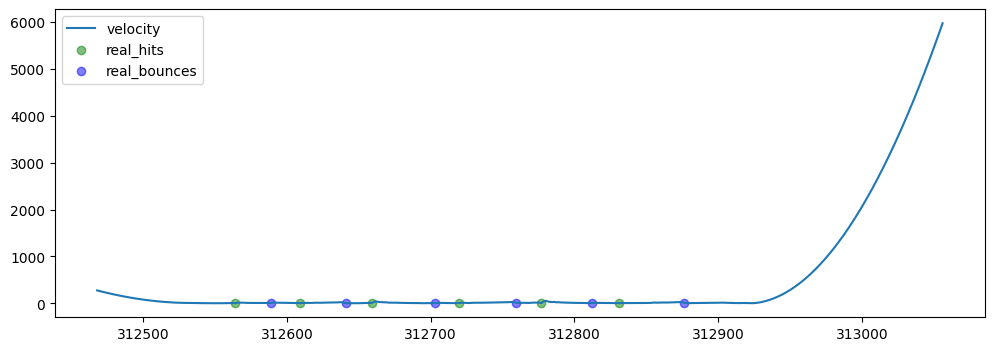

In [176]:
plt.figure(figsize=(12,4))
plt.plot(t, vy, label='vy')
plt.scatter(t[real_hits], v_score[real_hits], c='g', label="real_hits", alpha=0.5)
plt.scatter(t[real_bounces], v_score[real_bounces], c='b', label="real_bounces", alpha=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(t, vx, label='vx')
plt.scatter(t[real_hits], v_score[real_hits], c='g', label="real_hits", alpha=0.5)
plt.scatter(t[real_bounces], v_score[real_bounces], c='b', label="real_bounces", alpha=0.5)
plt.legend()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(t, np.sqrt(vx**2 + vy**2), label='velocity')
plt.scatter(t[real_hits], v_score[real_hits], c='g', label="real_hits", alpha=0.5)
plt.scatter(t[real_bounces], v_score[real_bounces], c='b', label="real_bounces", alpha=0.5)
plt.legend()
plt.show()


In [213]:
from scipy.signal import find_peaks

def detect_event_frames(score, height=4.5, distance=17):
    peaks, props = find_peaks(
        score,
        height=height,
        distance=distance
    )
    return peaks
event_frames = detect_event_frames(a_score)

In [214]:
frames = sorted(int(k) for k in ball_data.keys())
frame_to_idx = {f: i for i, f in enumerate(frames)}
idx_to_frame = {i: f for i, f in enumerate(frames)}

visible = [ball_data[str(f)]["visible"] for f in frames]


In [215]:
def snap_event_idx_to_visible(i, visible, max_search=10):
    if visible[i]:
        return i

    for d in range(1, max_search + 1):
        if i - d >= 0 and visible[i - d]:
            return i - d
        if i + d < len(visible) and visible[i + d]:
            return i + d

    return None


In [216]:
def clean_event_indices(event_idx, visible, max_search=10):
    cleaned = []

    for i in event_idx:
        j = snap_event_idx_to_visible(i, visible, max_search)
        if j is not None:
            cleaned.append(j)

    cleaned = sorted(set(cleaned))
    return cleaned
cleaned_event_idx = clean_event_indices(event_frames, visible)

cleaned_event_frames = np.array([frames[i] for i in cleaned_event_idx])


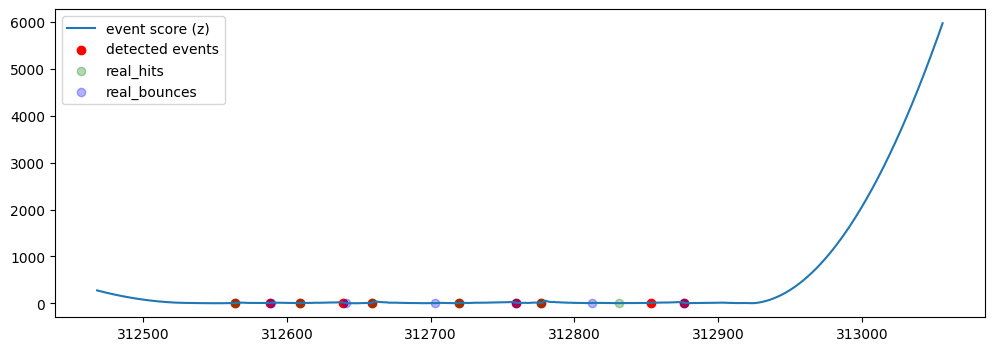

In [217]:
c= cleaned_event_frames - first_frame
plt.figure(figsize=(12,4))
plt.plot(t, v_score, label="event score (z)")
plt.scatter(t[c], v_score[c], c='r', label="detected events")
plt.scatter(t[real_hits], v_score[real_hits], c='g', label="real_hits", alpha=0.3)
plt.scatter(t[real_bounces], v_score[real_bounces], c='b', label="real_bounces", alpha=0.3)

plt.legend()
plt.show()


In [218]:

def count_invisible_before(frame, ball_data, window=10):
    c = 0
    for f in range(frame - 1, frame - window - 1, -1):
        if str(f) not in ball_data:
            break
        if ball_data[str(f)]["visible"] is False:
            c += 1
        else:
            break  # on s'arrête dès qu'on revoit la balle
    return c


In [219]:
events = sorted(cleaned_event_frames)

invisible_counts = [
    count_invisible_before(f, ball_data, window=10)
    for f in events
]

service_idx = int(np.argmax(invisible_counts))


In [220]:
event_labels = {}
event_labels[service_idx] = "hit"


In [221]:
for i in range(service_idx + 1, len(events)):
    prev = event_labels[i - 1]
    event_labels[i] = "bounce" if prev == "hit" else "hit"
for i in range(service_idx - 1, -1, -1):
    next_ = event_labels[i + 1]
    event_labels[i] = "bounce" if next_ == "hit" else "hit"

In [222]:
predicted_events = {
    events[i]: event_labels[i]
    for i in range(len(events))
}
predicted_events = {str(k): v for k, v in predicted_events.items()}


In [223]:
ball_data_modified = ball_data.copy()
for key in ball_data_modified:
    if key in predicted_events:
        ball_data_modified[key]["pred_action"] = predicted_events[key]
    else:
        ball_data_modified[key]["pred_action"] = 'air'

In [224]:
hit_pred_array = []
bounce_pred_array = []

for idx, value in enumerate(c):
    if event_labels[idx] == 'hit':
        hit_pred_array.append(value)
    else:
        bounce_pred_array.append(value)

hit_pred_array = np.array(hit_pred_array)
bounce_pred_array = np.array(bounce_pred_array)

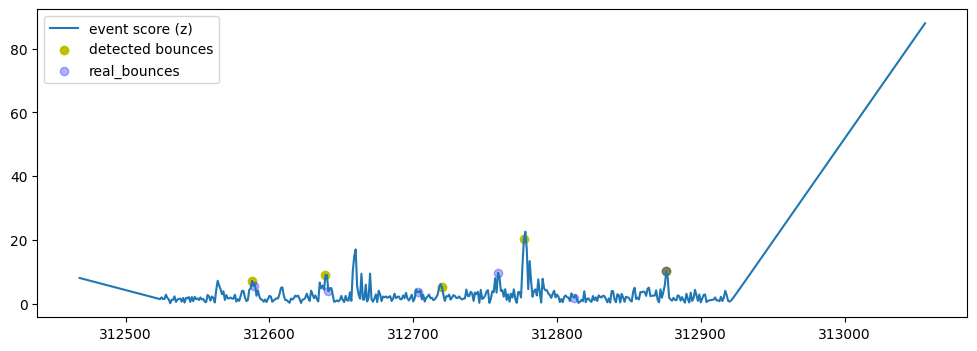

In [225]:
plt.figure(figsize=(12,4))
plt.plot(t, a_score, label="event score (z)")
plt.scatter(t[bounce_pred_array], a_score[bounce_pred_array], c='y', label="detected bounces")
plt.scatter(t[real_bounces], a_score[real_bounces], c='b', label="real_bounces", alpha=0.3)

plt.legend()
plt.show()

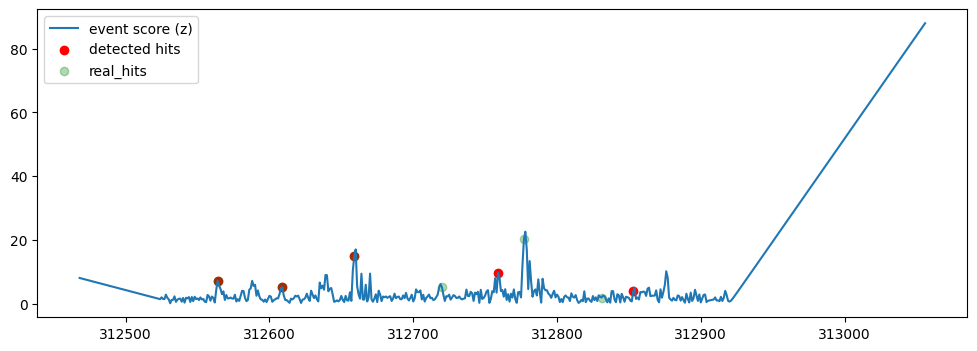

In [226]:
plt.figure(figsize=(12,4))
plt.plot(t, a_score, label="event score (z)")
plt.scatter(t[hit_pred_array], a_score[hit_pred_array], c='r', label="detected hits")
plt.scatter(t[real_hits], a_score[real_hits], c='g', label="real_hits", alpha=0.3)

plt.legend()
plt.show()